# 1、Introduction

This challenge comes from [#WOW2023 | Week 9 | A tricky filter](https://workout-wednesday.com/2023w09tab/). Its task mainly focuses on the interactivity of a bar chart.

I'll use `panel` for interactivity design, and `matplotlib` for the bar chart plotting. Without further ado, let's do it!

First import some compulsory libraries for the data manipulation and visualization design.

In [1]:
# For data manipulation
import pandas as pd

# For data visualization
# According https://panel.holoviz.org/reference/panes/Matplotlib.html, we should use 
# the matplotlib.figure api instead of matplotlib.pyplot api with panel
import matplotlib.figure as mfig

# For interactivity
import panel as pn
pn.extension('ipywidgets')

In [2]:
data_file = "./datasets/Superstore 2022.4.csv"
sale_data = pd.read_csv(data_file, index_col=0)
sale_data.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,State/Province,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Row ID,,,,,,,,,,,,,,,,,,,,
1,US-2019-103800,03/01/2019,07/01/2019,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,Texas,77095,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512
2,US-2019-112326,04/01/2019,08/01/2019,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540,2,0.8,-5.4870
3,US-2019-112326,04/01/2019,08/01/2019,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717
4,US-2019-112326,04/01/2019,08/01/2019,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748
5,US-2019-141817,05/01/2019,12/01/2019,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,Pennsylvania,19143,East,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536,3,0.2,4.8840


In [3]:
# Select the sales data from the State of Ohio
Ohio_data = sale_data.query("`State/Province` == 'Ohio'").loc[:, ["City", "Sales"]]
sales_Ohio = Ohio_data.groupby(by="City").sum()

key_cities = ['Cincinnati', 'Akron', 'Toledo', 'Cleveland', 'Columbus']
key_cities_data = sales_Ohio.loc[key_cities, :]

other_cities = [city for city in sales_Ohio.index if city not in key_cities]
other_cities_data = sales_Ohio.loc[other_cities, :]

key_cities_data

,Sales
City,
Cincinnati,1611.976
Akron,2729.986
Toledo,4466.053
Cleveland,6346.185
Columbus,15900.793


Matplotlib(Figure, height=504, width=720)
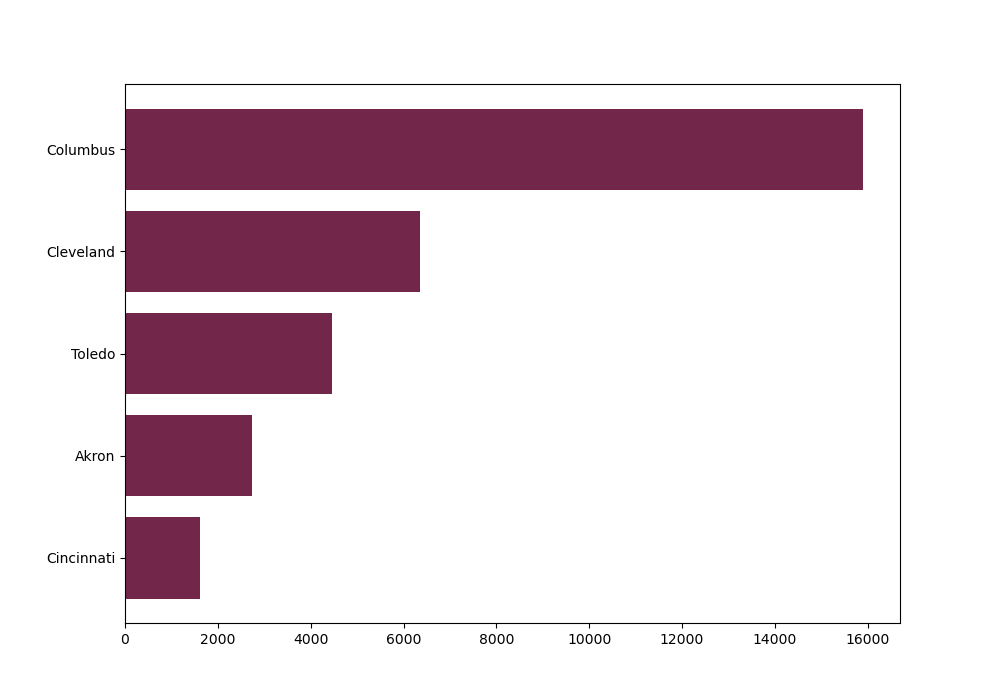

In [4]:
import matplotlib.pyplot as plt
px = 1 / plt.rcParams['figure.dpi']
colors = ["#71264A", "#D3D3D3"]

fig = mfig.Figure(figsize=(1000*px, 700*px))
ax = fig.subplots()

bar = ax.barh(y=key_cities_data.index, width=key_cities_data["Sales"], color=colors[0])

pn.pane.Matplotlib(fig)

Row
    [0] Column(width=450)
        [0] HTML(str)
        [1] Row
            [0] Markdown(str)
            [1] MultiSelect(options=['Bowling Green', ...], size=8)
        [2] Row
            [0] Markdown(str)
            [1] Select(options=['Key Cities', 'Sales'], value='Key Cities')
    [1] ParamFunction(function, _pane=Matplotlib)
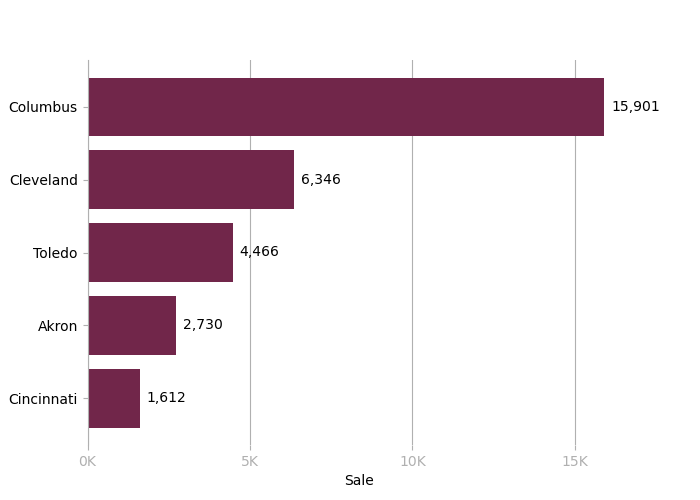

In [5]:
title = pn.pane.HTML("<h2><b># WOW2023 Week 9: A tricky filter</b></h2>" + 
                     "Can you allow users to filter out any city except for " +
                     f"a select few <span style='color:{colors[0]};font-weight:bold'>Key Cities</span>?")
selected_cities = pn.widgets.MultiSelect(value=[], options=list(other_cities_data.index), size=8)

sort_by = pn.widgets.Select(options=['Key Cities', 'Sales'], value='Key Cities')

widgets = pn.Column(title, 
                  pn.Row("Filter Cities", selected_cities), 
                  pn.Row("Sort By" + "&nbsp;"*7, sort_by), 
                  align="start", width=450)

def plot_bar(selected_cities=[], sort_by="Key Cities"):
    fig = mfig.Figure(figsize=(700*px, 500*px))
    ax = fig.subplots()
    
    key_cities_data['color'] = colors[0]
    
    if selected_cities:
        selected_data = other_cities_data.loc[selected_cities, :]
        selected_data['color'] = colors[1]
        if sort_by == "Key Cities":
            data = pd.concat([selected_data.sort_values(by="Sales"), key_cities_data])
        else:
            data = pd.concat([selected_data, key_cities_data]).sort_values(by="Sales")
    else:
        data = key_cities_data
        
    bars = ax.barh(y=data.index, width=data["Sales"], color=data["color"])
    
    ax.bar_label(bars, fmt="{:,.0f}", padding=5)
    ax.xaxis.set_ticks([0, 5000, 10000, 15000], labels=["0K", "5K", "10K", "15K"])
    ax.set_xlabel("Sale")
    
    ax.grid(True, axis='x')
    ax.set_axisbelow(True)
    grid_color = ax.xaxis.get_gridlines()[0].get_color()
    
    ax.spines[["bottom", "right", "top"]].set_visible(False)
    ax.spines["left"].set_color(grid_color)
    
    ax.tick_params(color=grid_color)
    ax.tick_params(labelcolor=grid_color, axis="x")
    
    return fig


iplot = pn.bind(plot_bar, selected_cities=selected_cities, sort_by=sort_by)

app = pn.Row(widgets, iplot).servable()
app